In [4]:
#region imports
from IPython import get_ipython

# noinspection PyBroadException
try:
    _magic = get_ipython().run_line_magic
    _magic("load_ext", "autoreload")
    _magic("autoreload", "2")
except:
    pass

# noinspection PyUnresolvedReferences
import datetime as dt
# noinspection PyUnresolvedReferences
import glob
# noinspection PyUnresolvedReferences
import os
# noinspection PyUnresolvedReferences
import pprint
# noinspection PyUnresolvedReferences
import sys
# noinspection PyUnresolvedReferences
import cartopy as crt
# noinspection PyUnresolvedReferences
import matplotlib as mpl
# noinspection PyUnresolvedReferences
import matplotlib.colors
# noinspection PyUnresolvedReferences
import matplotlib.pyplot as plt
# noinspection PyUnresolvedReferences
import numpy as np
# noinspection PyUnresolvedReferences
import pandas as pd
# noinspection PyUnresolvedReferences
import seaborn as sns
# noinspection PyUnresolvedReferences
import xarray as xr
# noinspection PyUnresolvedReferences
#import bnn_tools.bnn_array
import bnn_tools.basic_funs as bu
import funs as fu

plt.style.use('default')
xr.set_options(
    display_expand_data = False,
    display_expand_data_vars = True,
    display_max_rows = 10,
    display_style = 'html',
    display_width = 80,
    display_expand_attrs = False
);
#endregion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
p = '../data/data_orig/hyytiälä_number_size_distribution_np.csv'

In [6]:
ds_ = (
    pd.read_csv(p,
                parse_dates=[0])
    .set_index('Unnamed: 0')
    .stack()
    .to_xarray()
    .rename({'Unnamed: 0':'time'})
    .rename({'level_1':'Dp'})
    .assign_coords({'Dp':lambda d:d['Dp'].astype(float)*1e-9})
    .rename('dndlDp')
    .sortby('time')
    .resample({'time':'15T'}).median()
)

In [7]:
ds_.drop_duplicates(dim='time')

<xarray.DataArray 'dndlDp' (time: 167097, Dp: 20)>
1.22e+03 890.6 697.5 337.7 155.2 ... 8.035e+03 6.921e+03 5.184e+03 3.323e+03
Coordinates:
  * Dp       (Dp) float64 2.738e-09 3.162e-09 3.652e-09 ... 3.652e-08 4.217e-08
  * time     (time) datetime64[ns] 2018-01-01 ... 2022-10-07T14:00:00

In [8]:
ds_

<xarray.DataArray 'dndlDp' (time: 167097, Dp: 20)>
1.22e+03 890.6 697.5 337.7 155.2 ... 8.035e+03 6.921e+03 5.184e+03 3.323e+03
Coordinates:
  * Dp       (Dp) float64 2.738e-09 3.162e-09 3.652e-09 ... 3.652e-08 4.217e-08
  * time     (time) datetime64[ns] 2018-01-01 ... 2022-10-07T14:00:00

In [9]:
ds = (
    ds_
    .pipe(bu.dp_regrid,log_dy=.05,n_subs=10)
    .pipe(bu.set_Dp)
    .pipe(bu.upsample_ts,15*60)
)

In [10]:
ds.to_netcdf('../data/d1/npsd-hy-nais.nc')

In [11]:
ds

<xarray.DataArray 'dndlDp' (time: 167097, Dp: 25)>
1.167e+03 914.7 741.2 496.0 272.0 ... 6.916e+03 5.599e+03 4.142e+03 2.876e+03
Coordinates:
    lDp      (Dp) float64 -8.55 -8.5 -8.45 -8.4 -8.35 ... -7.5 -7.45 -7.4 -7.35
  * Dp       (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 3.981e-08 4.467e-08
  * time     (time) datetime64[ns] 2018-01-01 ... 2022-10-07T14:00:00

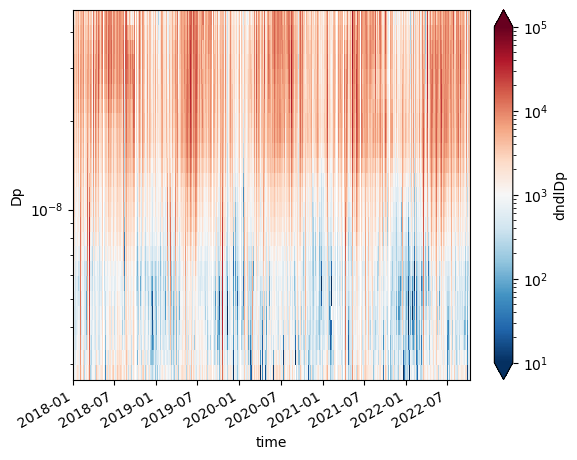

In [12]:
(
    ds.plot(
        x='time',
        yscale='log',
        norm = mpl.colors.LogNorm(vmin=1e1,vmax=1e5)
    )
)

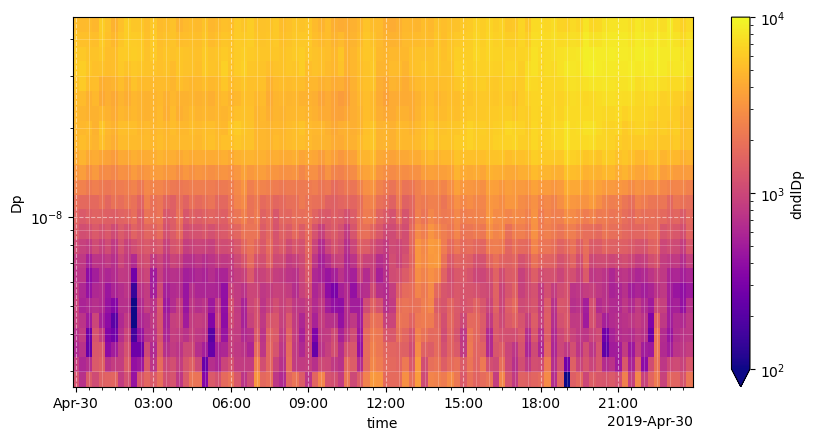

In [13]:
(
    ds
    .loc[{'time':'2019-04-30'}]
    .pipe(bu.plot_psd,vmin=1e2,vmax=1e4)
)

In [14]:
ds2 = (
    ds
    .pipe(fu.unstack_day)
    .assign_coords({'d':lambda d:xr.zeros_like(d['day'],dtype=int)+np.arange(len(d['day']))})
    .swap_dims({'day':'d'})
)

In [15]:
ds2

<xarray.DataArray 'dndlDp' (Dp: 25, d: 1741, hour: 96)>
1.167e+03 1.587e+03 1.585e+03 1.918e+03 2.102e+03 ... nan nan nan nan nan
Coordinates:
    day      (d) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-10-06 2022-10-07
  * hour     (hour) float64 0.0 0.25 0.5 0.75 1.0 ... 23.0 23.25 23.5 23.75
    lDp      (Dp) float64 -8.55 -8.5 -8.45 -8.4 -8.35 ... -7.5 -7.45 -7.4 -7.35
  * Dp       (Dp) float64 2.818e-09 3.162e-09 3.548e-09 ... 3.981e-08 4.467e-08
    t        (d, hour) datetime64[ns] 2018-01-01 2018-01-01T00:15:00 ... NaT NaT
  * d        (d) int64 0 1 2 3 4 5 6 7 ... 1734 1735 1736 1737 1738 1739 1740

In [20]:
sp = np.array_split(ds2['d'],35)

In [21]:

# for s in sp:
#     (
#         ds2
#         .loc[{'d':s}]
#         .plot(
#             y='Dp',
#             yscale='log',
#             norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e5),
#             cmap = 'plasma',
#             col='d',
#             col_wrap=5,
#             size=1.2,
#             aspect = 1.6,
#             rasterized = True
#         )
# 
#     )

In [22]:
bad_days = [388,656,657,728,729,730,789,965,966,1053,1333]

In [23]:
# (
#     ds2
#     .loc[{'d':bad_days}]
#     .plot(
#         y='Dp',
#         yscale='log',
#         norm = mpl.colors.LogNorm(vmin=1.5e2,vmax=1e5),
#         cmap = 'plasma',
#         col='d',
#         col_wrap=5,
#         size=1.2,
#         aspect = 1.6,
#         rasterized = True
#     )
# 
# )

In [24]:
(
    ds2
    .loc[{'d':bad_days}]
    ['day']
    .swap_dims({'d':'day'})
    .to_netcdf('../data/d1/nais_bad_day.nc')
)